In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from collections import OrderedDict


# Function to create the rotation matrix for RoPE embeddings
def generate_rotation_matrix(seq_length, embed_dim):
    # [INSTRUCTION] Complete this function to generate a rotation matrix for RoPE embeddings.
    # The matrix rotates queries and keys based on sequence position and embedding dimension.
    # Hint: Consider using the provided exponential decay formula for theta and apply trigonometric rotations.
    pass  # Implement your function based on the hint
    # Initialize the rotation matrix R
    R = torch.zeros((seq_length, embed_dim, embed_dim))

    # Create positions tensor from 1 to seq_length
    positions = torch.arange(1, seq_length + 1).unsqueeze(1)  # shape: (seq_length, 1)

    # Calculate theta values based on the formula
    theta = positions / torch.pow(10000, torch.arange(0, embed_dim, 2).float() / embed_dim)

    # Calculate sin and cos values
    sin_values = torch.sin(theta.unsqueeze(-1))  # shape: (seq_length, embed_dim // 2, 1)
    cos_values = torch.cos(theta.unsqueeze(-1))  # shape: (seq_length, embed_dim // 2, 1)

    # Expand sin and cos values to match the dimensions of R
    sin_expanded = sin_values.repeat(1, 1, embed_dim // 2)  # shape: (seq_length, embed_dim // 2, embed_dim // 2)
    cos_expanded = cos_values.repeat(1, 1, embed_dim // 2)  # shape: (seq_length, embed_dim // 2, embed_dim // 2)

    for i in range(embed_dim // 2):
        R[:, 2 * i, 2 * i] = cos_expanded[:, i, i]
        R[:, 2 * i, 2 * i + 1] = -sin_expanded[:, i, i]
        R[:, 2 * i + 1, 2 * i] = sin_expanded[:, i, i]
        R[:, 2 * i + 1, 2 * i + 1] = cos_expanded[:, i, i]

    return R

In [2]:
# Custom RMS Normalization layer
class RMSNorm(nn.Module):
    def __init__(self, layer_dims, epsilon=1e-8):
        super().__init__()
        self.register_parameter("gamma", nn.Parameter(torch.ones(layer_dims)))
        self.epsilon = epsilon

    def forward(self, tensor_input):
        # [INSTRUCTION] Complete the forward method to normalize the input tensor using RMSNorm.
        # Compute the root mean square of the tensor values and use it to normalize the tensor_input.
        # Consider dimensions appropriately for batch processing and do not forget to add epsilon for numerical stability.
        pass  # Implement your normalization logic here
        mean_rms = torch.sqrt(torch.mean(tensor_input**2, dim=tuple(range(1, len(tensor_input.shape))), keepdim=True) + self.epsilon)

        normalized = tensor_input / mean_rms

        return normalized * self.gamma.to(normalized.device)

In [3]:
import math
# Attention head with RoPE embeddings and masking
class AttentionHeadWithRoPE(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        # [INSTRUCTION] Initialize linear layers for queries, keys, and values.
        # Each should transform input data to the same embedding dimensionality, and none should include bias terms.
        pass  # Initialize query, key, and value linear transformations here

        # [INSTRUCTION] Retrieve the rotation matrix generated for RoPE embeddings, ensuring it is moved to the correct device.
        pass  # Load the rotation matrix here

        embed_dim = params['embed_dim']

        # Initialize linear layers for queries, keys, and values
        self.query_linear = nn.Linear(embed_dim, embed_dim, bias=False)
        self.key_linear = nn.Linear(embed_dim, embed_dim, bias=False)
        self.value_linear = nn.Linear(embed_dim, embed_dim, bias=False)

        self.register_buffer('rotation_matrix', params['rotation_matrix'].to(params['device']))

    def forward(self, data_input, return_attention=False):
        batch_size, seq_len, embed_dim = data_input.shape
        # [INSTRUCTION] Transform the input data into queries, keys, and values using the respective linear layers.
        pass  # Transform data_input into queries, keys, and values here

        # [INSTRUCTION] Apply the RoPE rotation to both queries and keys. Think about the tensor shapes for matrix multiplication.
        pass  # Apply RoPE rotation to queries and keys here

        # [INSTRUCTION] Compute scaled dot-product attention. Remember to handle masking if 'return_attention' is true.
        # Optionally return attention weights for visualization or debugging.
        pass  # Compute attention and optionally return attention weights
        batch_size, seq_len, embed_dim = data_input.shape

        queries = self.query_linear(data_input)
        keys = self.key_linear(data_input)
        values = self.value_linear(data_input)

        rotated_queries = torch.bmm(queries, self.rotation_matrix)
        rotated_keys = torch.bmm(keys, self.rotation_matrix)

        attention_scores = torch.bmm(rotated_queries, rotated_keys.transpose(1, 2))
        attention_scores = attention_scores / math.sqrt(embed_dim)

        if return_attention:
            return attention_scores

        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_output = torch.bmm(attention_weights, values)
        attention_output = attention_output.transpose(1, 2).reshape(batch_size, seq_len, embed_dim)

        return attention_output

In [4]:
# Multi-head attention module
class MultiHeadAttention(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        # [INSTRUCTION] Initialize multiple attention heads.
        # Create a ModuleList of AttentionHeadWithRoPE instances, one for each attention head specified in 'params'.
        pass  # Initialize attention heads here

        # [INSTRUCTION] Define an output linear transformation that combines the outputs of all heads.
        # This linear layer should project from the concatenated dimension back to the embedding size.
        pass  # Initialize output linear transformation here

        # [INSTRUCTION] Add dropout for regularization after combining the outputs of the attention heads.
        pass  # Initialize dropout layer here

        embed_dim = params['embed_dim']
        num_heads = params['num_heads']

        self.attention_heads = nn.ModuleList([AttentionHeadWithRoPE(params) for _ in range(num_heads)])

        self.output_linear = nn.Linear(embed_dim * num_heads, embed_dim)

        self.dropout = nn.Dropout(params['dropout'])

    def forward(self, data_input):
        # [INSTRUCTION] Compute the output for each attention head and concatenate them along the last dimension.
        pass  # Compute and concatenate attention head outputs here

        # [INSTRUCTION] Apply the output linear transformation and dropout to the concatenated output.
        pass  # Apply linear transformation and dropout here

        head_outputs = [head(data_input) for head in self.attention_heads]

        attention_output = torch.cat(head_outputs, dim=-1)

        output = self.dropout(self.output_linear(attention_output))

        return output

In [5]:

# Swish-Gated Linear Unit (SiGLU) activation function
class SwishGLU(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = nn.Parameter(torch.ones(1))

    def forward(self, data_input):
        # [INSTRUCTION] Implement the SwishGLU activation function.
        # The function should use a gated mechanism with a swish activation to modulate the input data.
        pass  # Implement your activation function here

        gate = torch.sigmoid(self.linear_gate(data_input)) * data_input
        activation = self.linear(data_input)
        output = gate + self.beta * activation
        return output

In [6]:
# Transformer block consisting of attention and feedforward layers
class LLamaBlock(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        # [INSTRUCTION] Define the RMS normalization layers 'norm1' and 'norm2'.
        # Each should be initialized with appropriate dimensions based on sequence length and embedding size.
        pass  # Initialize RMSNorm instances here

        # [INSTRUCTION] Initialize the attention head using the AttentionHeadWithRoPE class with given parameters.
        pass  # Initialize the attention head here

        # [INSTRUCTION] Define a feedforward network consisting of a linear layer followed by a SwishGLU activation.
        # Ensure the dimensionality matches the embedding size defined in params.
        pass  # Initialize the feedforward network here

        self.norm1 = RMSNorm(params['embed_dim'])
        self.norm2 = RMSNorm(params['embed_dim'])

        self.attention = MultiHeadAttention(params)

        self.ff_linear1 = nn.Linear(params['embed_dim'], params['embed_dim'])
        self.ff_activation = SwishGLU(params['embed_dim'])
        self.ff_linear2 = nn.Linear(params['embed_dim'], params['embed_dim'])

    def forward(self, data_input):
        # [INSTRUCTION] Implement the forward pass integrating normalization, attention, and feedforward layers.
        # Include residual connections for the attention and feedforward blocks.
        # Hint: Remember to apply normalization before and after the attention, as well as before the feedforward network.
        pass  # Implement the forward logic with residuals and integration of components

        norm1_output = self.norm1(data_input)

        attention_output = self.attention(norm1_output)
        attention_output = data_input + attention_output 

        norm2_output = self.norm2(attention_output)

        ff1_output = self.ff_linear1(norm2_output)
        ff_activation_output = self.ff_activation(ff1_output)
        ff_output = self.ff_linear2(ff_activation_output)
        output = attention_output + ff_output  
        return output

In [7]:
# LLaMA-like language model
class LLama(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        # [INSTRUCTION] Initialize the embedding layer for the input tokens.
        pass  # Initialize embedding layer here

        # [INSTRUCTION] Construct a sequence of transformer blocks using OrderedDict.
        # Use a loop to create a specified number of LLamaBlock instances based on 'transformer_blocks' in params.
        pass  # Create transformer blocks here

        # [INSTRUCTION] Define the final linear transformation layers.
        # This should include a linear layer to match the embedding dimension, a SwishGLU activation, and a final linear layer to map back to the vocabulary size.
        pass  # Initialize the final linear transformation layers here

        # Optionally print the total number of parameters in the model
        self.embedding = nn.Embedding(params['vocab_size'], params['embed_dim'])

        self.transformer_blocks = nn.ModuleDict()
        for i in range(params['transformer_blocks']):
            block_name = f"block_{i}"
            self.transformer_blocks[block_name] = LLamaBlock(params)

        self.final_linear1 = nn.Linear(params['embed_dim'], params['ff_dim'])
        self.final_activation = SwishGLU(params['ff_dim'])
        self.final_linear2 = nn.Linear(params['ff_dim'], params['vocab_size'])

        print("Model parameters:", sum([p.numel() for p in self.parameters()]))

    def forward(self, input_ids, target_ids=None):
        # [INSTRUCTION] Implement the forward pass of the model.
        # Embed the input_ids, process them through the LLama_blocks, and apply the final linear transformations.
        # If target_ids are provided, compute and return the cross-entropy loss along with the logits.
        pass  # Implement forward logic and loss computation here

        embed = self.embedding(input_ids)

        for block_name, block in self.transformer_blocks.items():
            embed = block(embed)

        logits = self.final_linear2(self.final_activation(self.final_linear1(embed)))

        loss = None
        if target_ids is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), target_ids.view(-1))

        return logits, loss

In [8]:
# Data preprocessing function
def prepare_data(file_path):
    # [INSTRUCTION] Open the file and read the text. Then create a list of unique characters and build two dictionaries:
    # one to convert characters to indices and another from indices to characters.
    pass  # Implement code to read file, create character list, and build dictionaries here
    # [INSTRUCTION] Convert the entire text into a tensor of indices corresponding to the characters.
    pass  # Convert characters in the text to indices and create a tensor here
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()

    unique_chars = list(set(text))
    char_to_idx = {char: idx for idx, char in enumerate(unique_chars)}
    idx_to_char = {idx: char for idx, char in enumerate(unique_chars)}
    vocabulary_size = len(unique_chars)

    data_tensor = torch.tensor([char_to_idx[char] for char in text])

    return data_tensor, vocabulary_size, char_to_idx, idx_to_char

# Function to create training batches
def batch_generator(data, split, batch_size, seq_len, params):
    # [INSTRUCTION] Split the data into training, validation, and test sets based on the provided ratios.
    # Consider using 80% of data for training, 10% for validation, and 10% for testing.
    pass  # Split the data into the appropriate segments here
    pass  # Select data for the current training or evaluation phase here
    # [INSTRUCTION] Generate random starting points for each batch and construct input and target sequences.
    # The target sequence for each input is simply the input sequence shifted by one position.
    pass  # Generate random batch start indices and construct input and target sequences here
    train_size = int(0.8 * len(data))
    val_size = int(0.1 * len(data))
    test_size = len(data) - train_size - val_size

    if split == 'train':
        dataset = data[:train_size]
    elif split == 'validation':
        dataset = data[train_size:train_size + val_size]
    else:
        dataset = data[train_size + val_size:]

    batch_start_indices = torch.randint(0, len(dataset) - seq_len - 1, (batch_size,))
    input_sequences = []
    target_sequences = []
    for start_idx in batch_start_indices:
        input_sequence = dataset[start_idx:start_idx + seq_len]
        target_sequence = dataset[start_idx + 1:start_idx + seq_len + 1]
        input_sequences.append(input_sequence)
        target_sequences.append(target_sequence)

    input_sequences = torch.stack(input_sequences)
    target_sequences = torch.stack(target_sequences)

    return input_sequences, target_sequences

In [9]:
# Function to evaluate model loss
@torch.no_grad()
def eval_loss(model, dataset, params):
    results = {}
    model.eval()
    for split in ["train", "validation"]:
        batch_losses = []
        for _ in range(10):
            input_batch, target_batch = batch_generator(dataset, split, params['training_batch'], params['sequence_length'], params)
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            _, batch_loss = model(input_batch, target_batch)
            batch_losses.append(batch_loss.item())
        results[split] = np.mean(batch_losses)
    model.train()
    return results

In [10]:
# Training loop
import time
import pandas as pd
def train_model(model, optimizer, dataset, params, scheduler=None):
    all_losses = []
    start = time.time()
    for epoch in range(params['training_epochs']):
        optimizer.zero_grad()
        input_batch, target_batch = batch_generator(dataset, 'train', params['training_batch'], params['sequence_length'], params)

        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)
        _, batch_loss = model(input_batch, target_batch)
        batch_loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if (epoch + 1) % params['logging_frequency'] == 0:
            time_elapsed = time.time() - start
            evaluation_result = eval_loss(model, dataset, params)
            all_losses.append(evaluation_result)
            print(
                f"Epoch {epoch + 1}/{params['training_epochs']} | "
                f"Validation Loss: {evaluation_result['validation']:.4f} | "
                f"Time: {time_elapsed:.2f}s"
            )
            start = time.time()
            if scheduler:
                print("lr: ", scheduler.get_lr())

    print("Final Validation Loss: ", all_losses[-1]['validation'])
    return pd.DataFrame(all_losses).plot()

GPU not found, using CPU for training.
Model parameters: 3617250
Epoch 1/100 | Validation Loss: 4.2033 | Time: 0.69s
Epoch 2/100 | Validation Loss: 3.7869 | Time: 0.63s
Epoch 3/100 | Validation Loss: 3.9715 | Time: 0.57s
Epoch 4/100 | Validation Loss: 3.4610 | Time: 0.58s
Epoch 5/100 | Validation Loss: 3.5068 | Time: 0.52s
Epoch 6/100 | Validation Loss: 3.3957 | Time: 0.52s
Epoch 7/100 | Validation Loss: 3.2429 | Time: 0.51s
Epoch 8/100 | Validation Loss: 3.0799 | Time: 0.52s
Epoch 9/100 | Validation Loss: 3.0626 | Time: 0.53s
Epoch 10/100 | Validation Loss: 3.0409 | Time: 0.52s
Epoch 11/100 | Validation Loss: 2.9892 | Time: 0.55s
Epoch 12/100 | Validation Loss: 2.9229 | Time: 0.52s
Epoch 13/100 | Validation Loss: 2.9040 | Time: 0.52s
Epoch 14/100 | Validation Loss: 2.8817 | Time: 0.52s
Epoch 15/100 | Validation Loss: 2.8524 | Time: 0.53s
Epoch 16/100 | Validation Loss: 2.8345 | Time: 0.61s
Epoch 17/100 | Validation Loss: 2.7967 | Time: 0.52s
Epoch 18/100 | Validation Loss: 2.7674 | Ti

TypeError: cannot unpack non-iterable Axes object

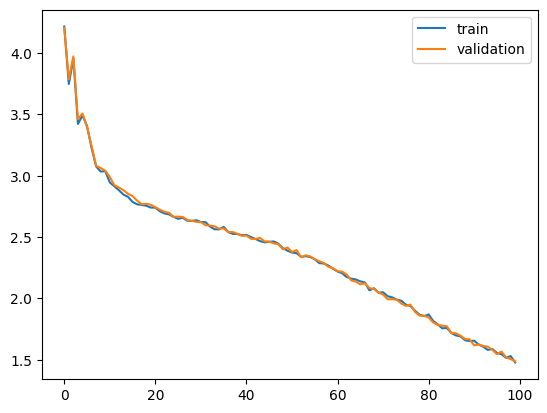

In [12]:
data_path = "/Users/zihadeev/Downloads/input.txt"
dataset, vocab_size, char_to_idx, idx_to_char = prepare_data(data_path)

MODEL_PARAMS = {
    'vocab_size': vocab_size,
    'embed_dim': 128,
    'sequence_length': 64,
    'training_batch': 64,
    'training_epochs': 100,
    'logging_frequency': 1,
    'num_heads': 8,
    'transformer_blocks': 6,
    'ff_dim': 128,
    'dropout': 0.1,
    'rotation_matrix': generate_rotation_matrix(64, 128),
}

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU for training.")
    MODEL_PARAMS['device'] = 'cuda'
else:
    device = torch.device('cpu')
    print("GPU not found, using CPU for training.")
    MODEL_PARAMS['device'] = 'cpu'

if torch.cuda.device_count() > 1:
    print(f"Distributing training across {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(LLama(MODEL_PARAMS)).to(device)
else:
    model = LLama(MODEL_PARAMS).to(device)

dataset = dataset.to(device)

optimizer = torch.optim.Adam(model.parameters())

_, _ = train_model(model, optimizer, dataset, MODEL_PARAMS)

In [13]:
MODEL_PARAMS = {
    'vocab_size': vocab_size,
    'embed_dim': 256,             # Increased embedding dimension
    'sequence_length': 64,
    'training_batch': 64,
    'training_epochs': 100,
    'logging_frequency': 1,
    'num_heads': 16,              # Increased number of attention heads
    'transformer_blocks': 12,      # Increased number of transformer blocks
    'ff_dim': 128,
    'dropout': 0.1,
    'rotation_matrix': generate_rotation_matrix(64, 256),  # Adjusted rotation matrix dimensions
}


In [14]:
# Original configuration
embed_dim = 128
num_heads = 8
transformer_blocks = 6

original_params = (
    vocab_size * embed_dim +

    transformer_blocks * (
        2 * embed_dim +

        num_heads * (
            3 * embed_dim * embed_dim +

            embed_dim * embed_dim
        ) +

        3 * embed_dim * embed_dim
    ) +

    2 * embed_dim * 128 
)

print("Original number of parameters:", original_params)


Original number of parameters: 3486592


In [15]:
embed_dim = 256
num_heads = 16
transformer_blocks = 12

updated_params = (
    vocab_size * embed_dim +

    transformer_blocks * (
        2 * embed_dim +

        num_heads * (
            3 * embed_dim * embed_dim +

            embed_dim * embed_dim
        ) +

        3 * embed_dim * embed_dim
    ) +

    2 * embed_dim * 128  
)

print("Updated number of parameters:", updated_params)


Updated number of parameters: 52785920


In [16]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU for training.")
    MODEL_PARAMS['device'] = 'cuda'
else:
    device = torch.device('cpu')
    print("GPU not found, using CPU for training.")
    MODEL_PARAMS['device'] = 'cpu'
if torch.cuda.device_count() > 1:
    print(f"Distributing training across {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(LLama(MODEL_PARAMS)).to(device)
else:
    model = LLama(MODEL_PARAMS).to(device)

dataset = dataset.to(device)

optimizer = torch.optim.Adam(model.parameters())

_, _ = train_model(model, optimizer, dataset, MODEL_PARAMS)

GPU not found, using CPU for training.
Model parameters: 53599848
Epoch 1/100 | Validation Loss: 4.2892 | Time: 5.97s
Epoch 2/100 | Validation Loss: 4.2632 | Time: 5.82s
Epoch 3/100 | Validation Loss: 3.8099 | Time: 4.87s
Epoch 4/100 | Validation Loss: 3.6838 | Time: 5.03s
Epoch 5/100 | Validation Loss: 3.7284 | Time: 6.37s
Epoch 6/100 | Validation Loss: 3.5935 | Time: 5.91s
Epoch 7/100 | Validation Loss: 3.4153 | Time: 6.61s
Epoch 8/100 | Validation Loss: 3.1729 | Time: 5.03s
Epoch 9/100 | Validation Loss: 3.0512 | Time: 4.96s
Epoch 10/100 | Validation Loss: 2.9873 | Time: 5.03s
Epoch 11/100 | Validation Loss: 2.9548 | Time: 5.58s
Epoch 12/100 | Validation Loss: 3.0905 | Time: 5.28s
Epoch 13/100 | Validation Loss: 3.1540 | Time: 5.50s
Epoch 14/100 | Validation Loss: 2.9198 | Time: 5.21s
Epoch 15/100 | Validation Loss: 2.8767 | Time: 5.06s
Epoch 16/100 | Validation Loss: 2.8783 | Time: 4.99s
Epoch 17/100 | Validation Loss: 2.7710 | Time: 5.08s
Epoch 18/100 | Validation Loss: 2.8073 | T

KeyboardInterrupt: 

We increased the number of parameters and adjusted them. It changed the validation loss, but I can't see that much of a difference. Only can say that the time that it took to train the model has risen significantly. For the more accurate and precise results we need more computational resources. I think that increasing the number of model's praramters is not enough to achieve now a better performance. We need more resources and time for that.

In [17]:
class AttentionHeadWithRoPE(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        embed_dim = params['embed_dim']

        self.query_linear = nn.Linear(embed_dim, embed_dim, bias=False)
        self.key_linear = nn.Linear(embed_dim, embed_dim, bias=False)
        self.value_linear = nn.Linear(embed_dim, embed_dim, bias=False)

        self.register_buffer('query_cache', None)
        self.register_buffer('key_cache', None)
        self.register_buffer('value_cache', None)

    def forward(self, data_input, return_attention=False):
        batch_size, seq_len, embed_dim = data_input.shape

        if self.query_cache is None:
            self.query_cache = self.query_linear(data_input)
        if self.key_cache is None:
            self.key_cache = self.key_linear(data_input)
        if self.value_cache is None:
            self.value_cache = self.value_linear(data_input)

        attention_scores = torch.bmm(self.query_cache, self.key_cache.transpose(1, 2))
        attention_scores = attention_scores / math.sqrt(embed_dim)

        if return_attention:
            return attention_scores

        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_output = torch.bmm(attention_weights, self.value_cache)
        attention_output = attention_output.transpose(1, 2).reshape(batch_size, seq_len, embed_dim)

        return attention_output


In [18]:
class MultiHeadAttention(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        embed_dim = params['embed_dim']
        num_heads = params['num_heads']
        self.heads_per_group = params.get('heads_per_group', num_heads)

        # Initialize attention heads and KV caches
        self.attention_heads = nn.ModuleList([AttentionHeadWithRoPE(params) for _ in range(num_heads)])
        self.output_linear = nn.Linear(embed_dim * num_heads, embed_dim)
        self.dropout = nn.Dropout(params['dropout'])

    def forward(self, data_input):
        batch_size, seq_len, embed_dim = data_input.shape

        # Group attention heads into smaller groups
        grouped_heads = [self.attention_heads[i:i+self.heads_per_group] for i in range(0, len(self.attention_heads), self.heads_per_group)]

        head_outputs = []
        for group in grouped_heads:
            group_output = torch.cat([head(data_input) for head in group], dim=-1)
            head_outputs.append(group_output)

        attention_output = torch.cat(head_outputs, dim=-1)
        output = self.dropout(self.output_linear(attention_output))

        return output


In [19]:
data_path = "/Users/zihadeev/Downloads/input.txt"
dataset, vocab_size, char_to_idx, idx_to_char = prepare_data(data_path)

augmented_dataset = torch.cat([dataset, dataset])

MODEL_PARAMS['vocab_size'] = vocab_size
MODEL_PARAMS['sequence_length'] = 64  
MODEL_PARAMS['dataset_size'] = len(augmented_dataset)

model = LLama(MODEL_PARAMS).to(device)
augmented_dataset = augmented_dataset.to(device)

optimizer = torch.optim.Adam(model.parameters())

_, _ = train_model(model, optimizer, augmented_dataset, MODEL_PARAMS)


Model parameters: 53599848
Epoch 1/100 | Validation Loss: 4.0328 | Time: 5.40s


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [20]:
def evaluate_and_plot(model, dataset, params):
    results = eval_loss(model, dataset, params)
    validation_losses = [result['validation'] for result in results]
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss over Epochs')
    plt.legend()
    plt.show()

evaluate_and_plot(model, dataset, MODEL_PARAMS)

evaluate_and_plot(model, augmented_dataset, MODEL_PARAMS)


TypeError: string indices must be integers, not 'str'